# <font color='red'> Risk analysis by clustering and pipelines

1. Problem defining
2. EDA
3. Features
4. Data Preprocessing
5. Kmeans Clustering
6. XGB and more

In [46]:
import warnings
warnings.filterwarnings('ignore')

# 1. Problem defining

 ##  <font color='blue'> - Evaluating the risk involved with a loan.
 ## <font color='blue'>  - Customer segmentation based on risks and other factors.
 ## <font color='blue'>  - Metrics and methods towards accurate customer loan risk management

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt#plt.style.use('fivethirtyeight')#sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from scipy.stats import uniform
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import silhouette_samples, silhouette_score
from bayes_opt import BayesianOptimization
df = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')

In [48]:
#show data frame
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

# Target distribution

In [49]:
df['Risk'].describe()

count     1000
unique       2
top       good
freq       700
Name: Risk, dtype: object

# 2. EDA
---

### Distributions

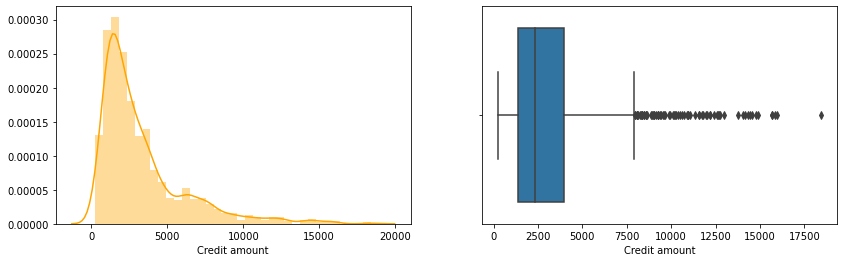

In [50]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.distplot(df['Credit amount'], color='orange',ax=ax[0]);
sns.boxplot(df['Credit amount'],ax=ax[1]);

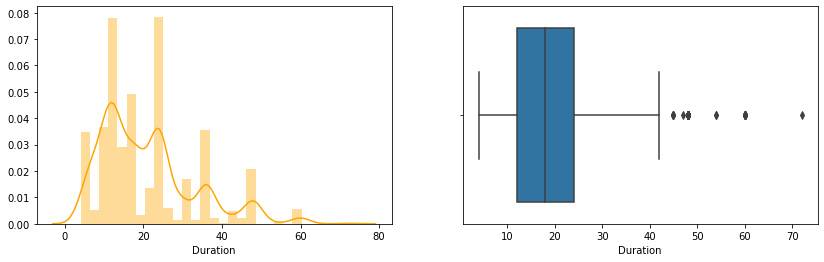

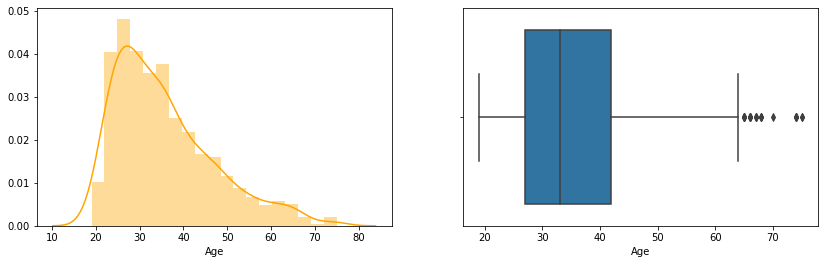

In [51]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.distplot(df['Duration'],  color='orange',ax=ax[0]);
sns.boxplot(df['Duration'],ax=ax[1]);

fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.distplot(df['Age'],  color='orange',ax=ax[0]);
sns.boxplot(df['Age'],ax=ax[1]);

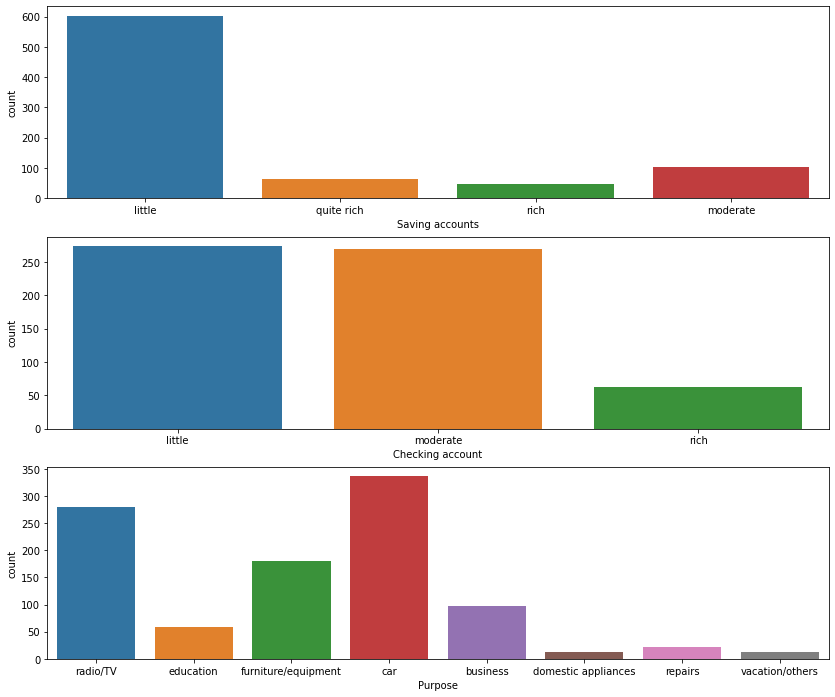

In [52]:
fig, ax = plt.subplots(3,1,figsize=(14,12))
sns.countplot(df['Saving accounts'], ax=ax[0]);
sns.countplot(df['Checking account'], ax=ax[1]);
sns.countplot(df.Purpose, ax=ax[2]);

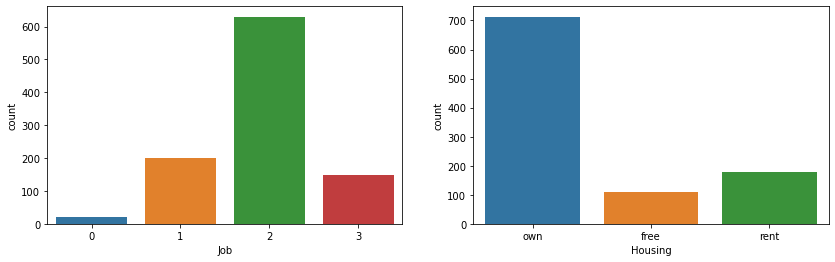

In [53]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.countplot(df['Job'], ax=ax[0]);
sns.countplot(df.Housing, ax=ax[1]);

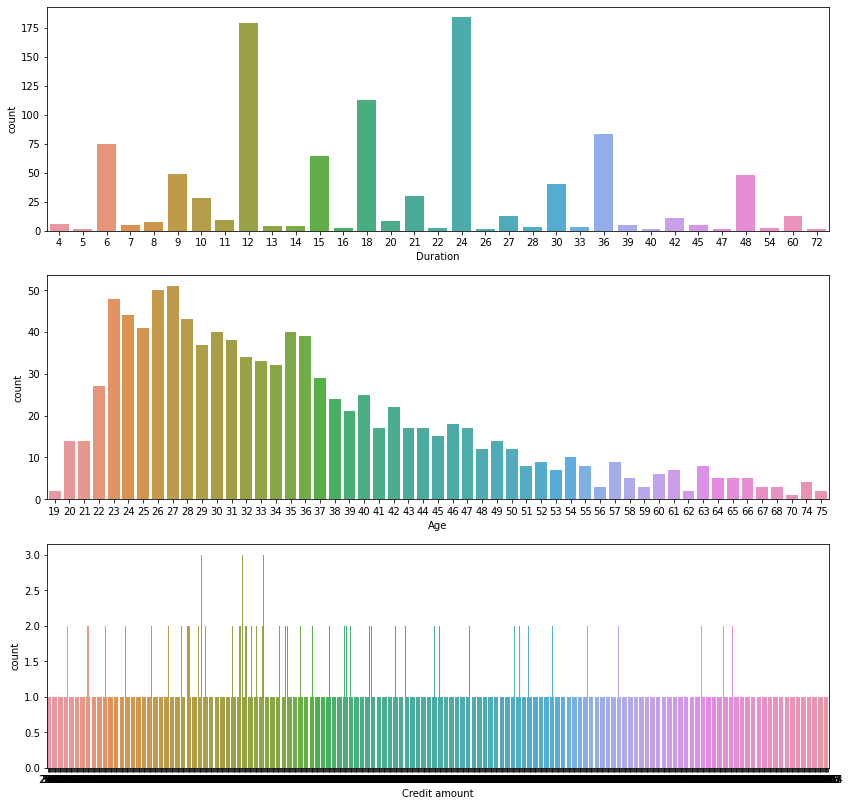

In [54]:
fig, ax = plt.subplots(3,1,figsize=(14,14))
sns.countplot(df.Duration, ax=ax[0]);
sns.countplot(df.Age, ax=ax[1]);
sns.countplot(df['Credit amount'], ax=ax[2]);

### Correlations

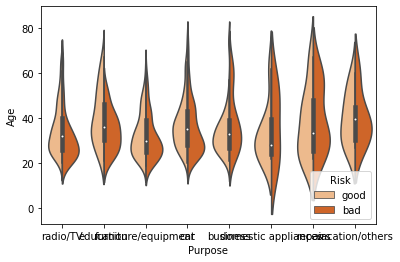

In [55]:
sns.violinplot(x="Purpose", y="Age", data=df, 
                    palette="Oranges", hue = "Risk",split=True)

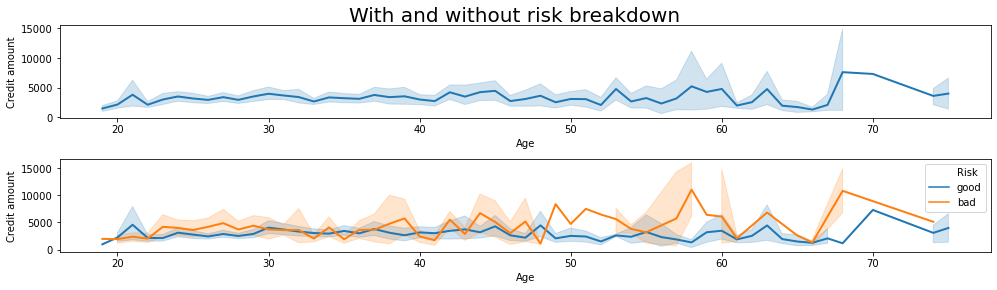

In [56]:
fig, ax = plt.subplots(2,1,figsize=(14,4))
plt.suptitle('With and without risk breakdown', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount',  lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Risk', lw=2, ax=ax[1]);



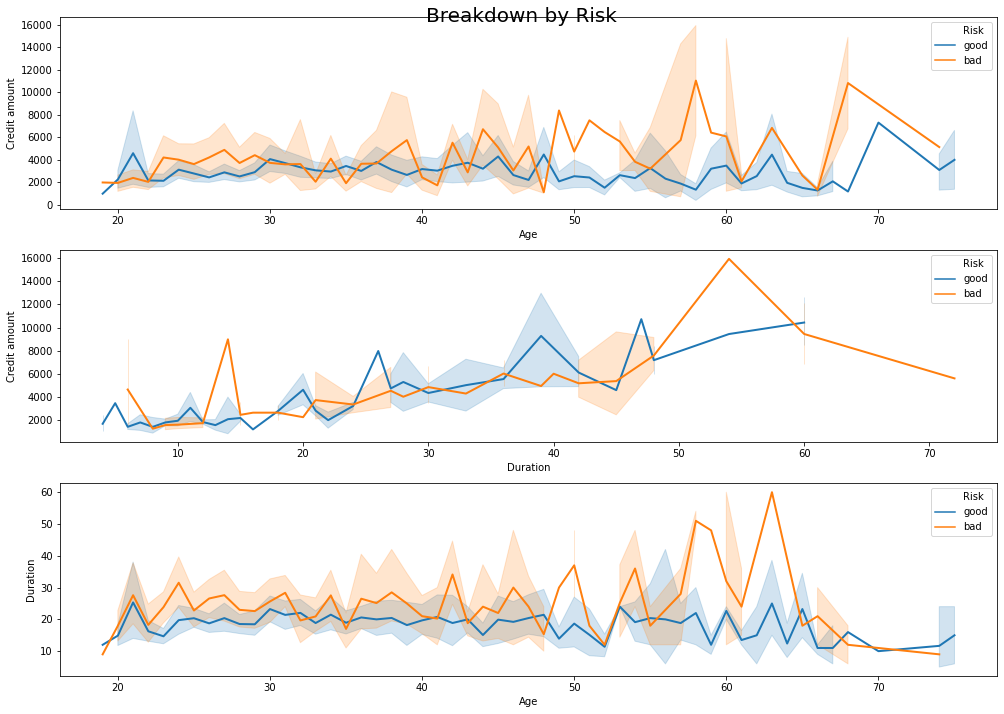

In [57]:
fig, ax = plt.subplots(3,1,figsize=(14,10))
plt.suptitle('Breakdown by Risk', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Risk', lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Risk', lw=2, ax=ax[1]);
sns.lineplot(data=df, x='Age', y='Duration', hue='Risk', lw=2, ax=ax[2]);


fig, ax = plt.subplots(3,1,figsize=(14,10))
plt.suptitle('Breakdown by Housing Type', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Housing', lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Housing', lw=2, ax=ax[1]);
sns.lineplot(data=df, x='Age', y='Duration', hue='Housing', lw=2, ax=ax[2]);

seaborn plot types:
https://www.mth548.org/Tools/Seaborn/seaborn_plot_types.html#:~:text=Some%20types%20of%20plots%20%28e.g.%20the%20scatter%20plot,subplots%2C%20one%20subplot%20for%20each%20pair%20of%20variables.

# Stripplots of  Risk, Job, and Housing Breakdown

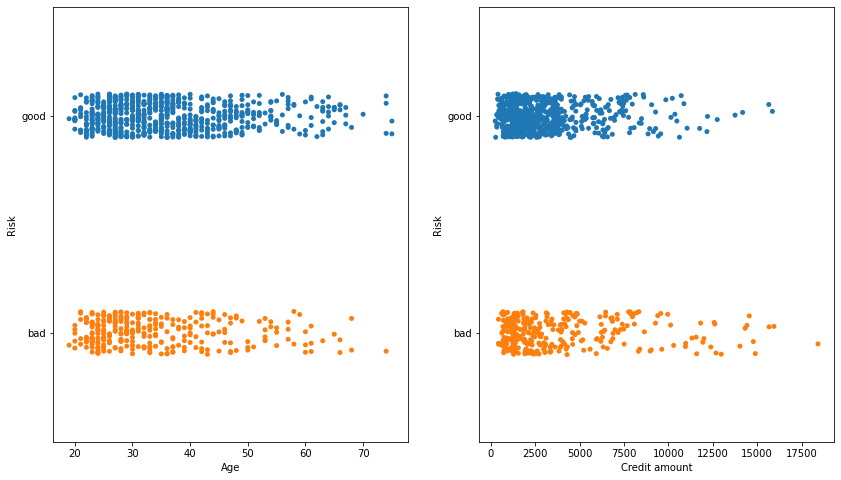

In [58]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Risk',   ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Risk',  ax=ax[1]);

fig, ax = plt.subplots(2,1,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Job',   ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Job',  ax=ax[1]);

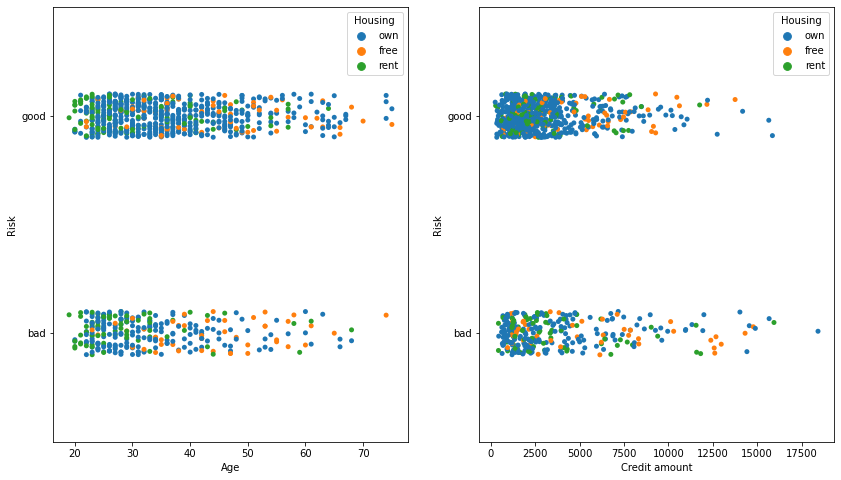

In [59]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Risk', hue='Housing',  ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Risk', hue='Housing', ax=ax[1]);

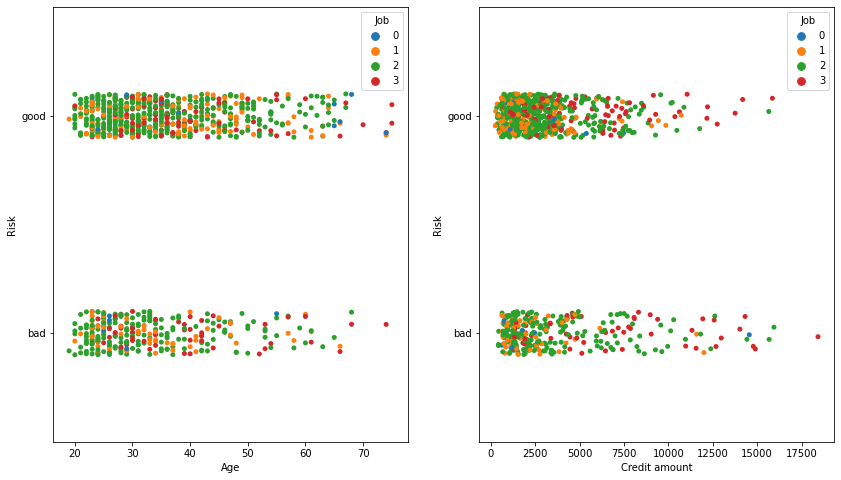

In [60]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Risk', hue='Job',  ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Risk', hue='Job', ax=ax[1]);

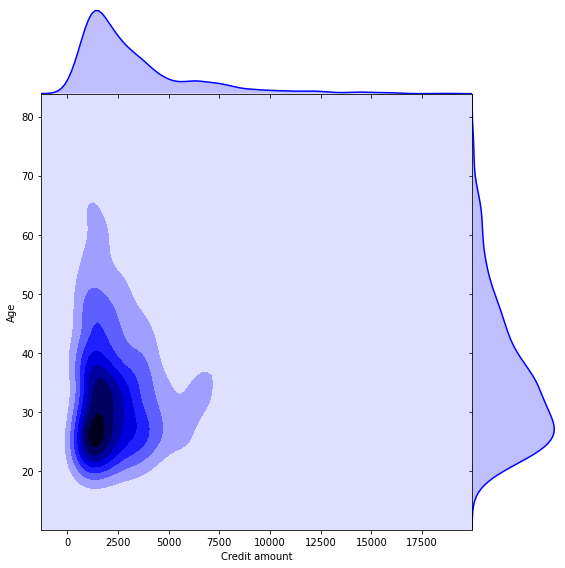

In [61]:
sns.jointplot(x=df["Credit amount"],y=df["Age"], kind="kde", space=0, color="b",data=df, height=8)


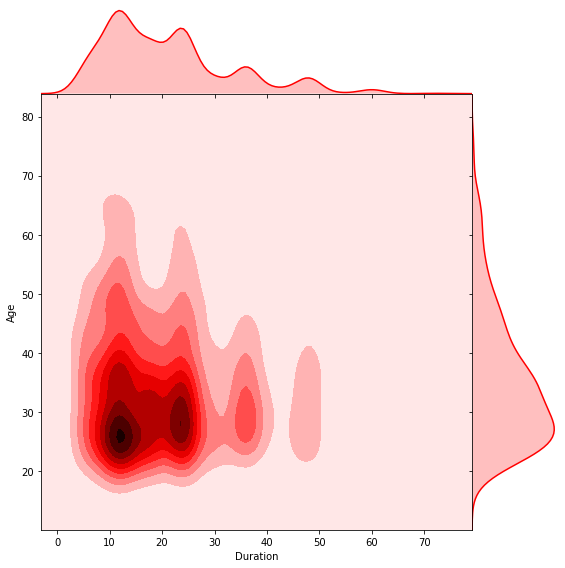

In [62]:
sns.jointplot(y=df["Age"],x=df["Duration"], kind="kde", space=0, color="r",data=df, height=8)


Text(0.5, 0, 'Purpose')

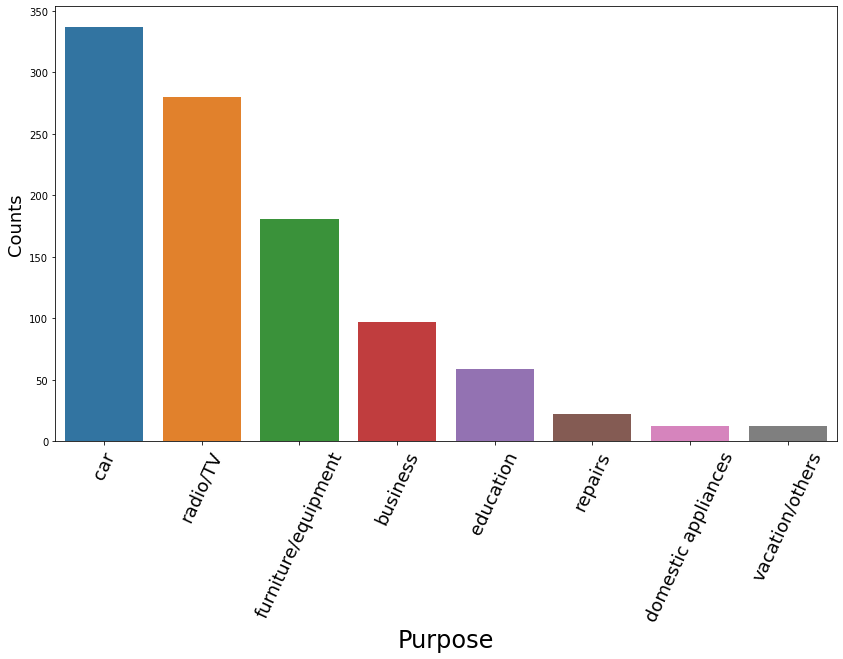

In [63]:
n_credits = df.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(14,8))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=65,fontsize=18)
plt.ylabel("Counts",fontsize=18)
plt.xlabel("Purpose",fontsize=24)

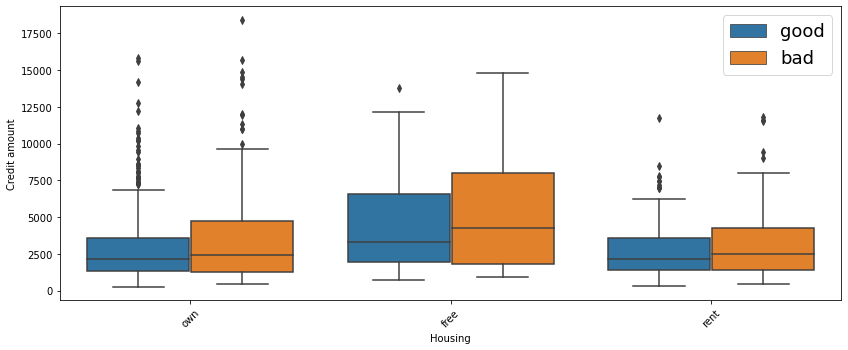

In [64]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(14,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=df)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.legend(fontsize=18)

boxes(df['Housing'],df["Credit amount"],df['Risk'])

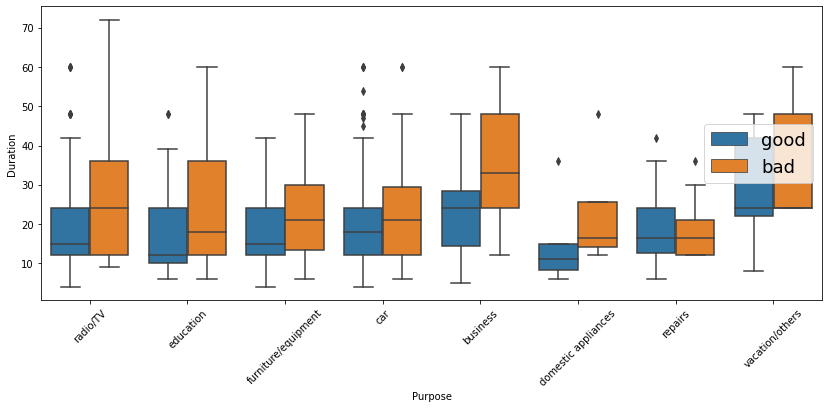

In [65]:
boxes("Purpose","Duration","Risk")

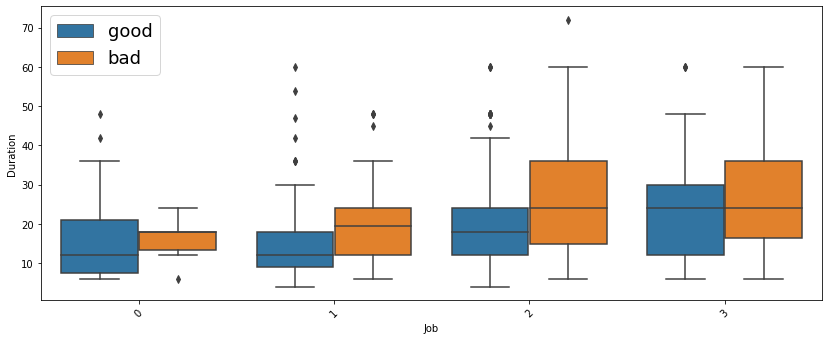

In [66]:
boxes("Job","Duration","Risk")

# 3. Features

In [67]:
df1=df[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']]

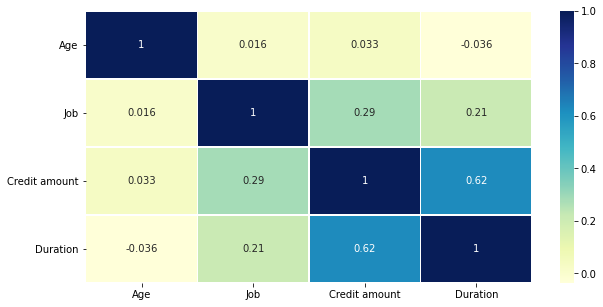

In [68]:

fig, ax = plt.subplots(figsize=(10,5))  
sns.heatmap(df1.corr(), cmap="YlGnBu", annot=True, linewidths=.5, ax=ax)

return_fig = sns.PairGrid(df1.dropna())
return_fig.map_upper(plt.scatter,alpha=0.5)
return_fig.map_lower(sns.kdeplot,color='purple')
return_fig.map_diag(plt.hist)

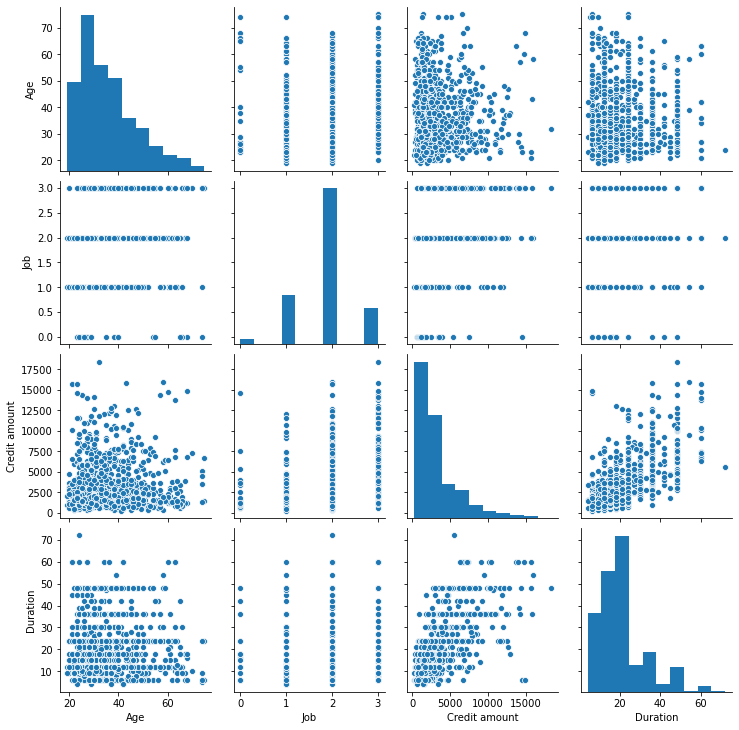

In [69]:

import matplotlib.pyplot as mp
import seaborn as sns
sns.pairplot(df1)

!pip install chart_studio

# 4. Data preprocessing: fillna, label encode, log transform, and scale
---

In [70]:
df1= df1.fillna('unknown')
df1.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [71]:
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for i, cat in enumerate(categorical_features):
    df1[cat] = LabelEncoder().fit_transform(df1[cat])
df1.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,3,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


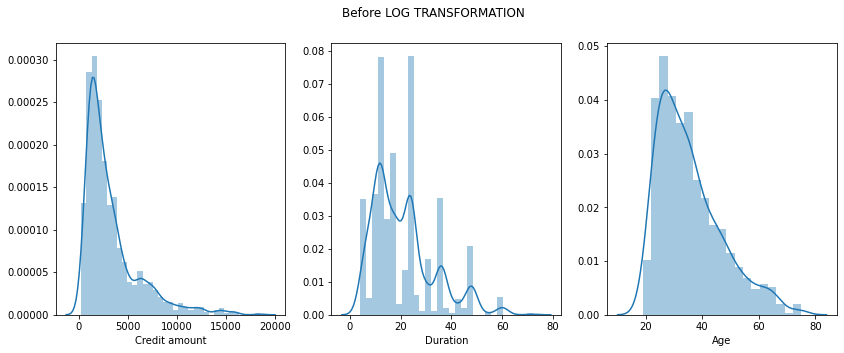

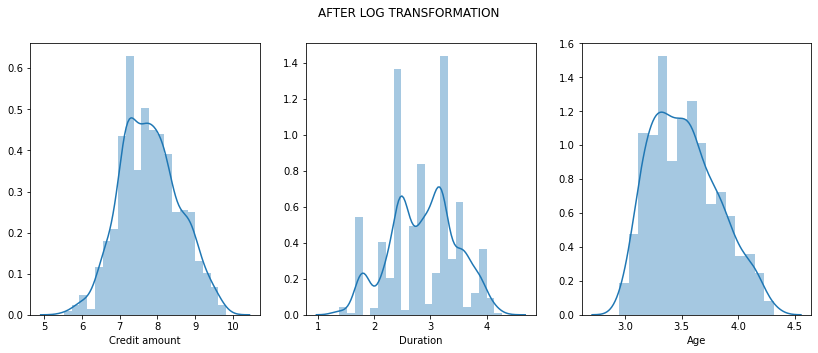

In [72]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
plt.suptitle('Before LOG TRANSFORMATION')
sns.distplot(df1['Credit amount'],  ax=ax[0]);
sns.distplot(df1['Duration'],ax=ax[1]);
sns.distplot(df1['Age'], ax=ax[2]);

num_df = df1[['Age', 'Duration', 'Credit amount']]
num_df = np.log(num_df)

fig, ax = plt.subplots(1,3,figsize=(14,5))
plt.suptitle('AFTER LOG TRANSFORMATION')
sns.distplot(num_df['Credit amount'],  ax=ax[0]);
sns.distplot(num_df['Duration'],ax=ax[1]);
sns.distplot(num_df['Age'], ax=ax[2]);

In [73]:
scaler = StandardScaler()
num_df_scaled = scaler.fit_transform(num_df)
print(num_df_scaled.shape)  #########

(1000, 3)


# 5. CLUSTERING
---

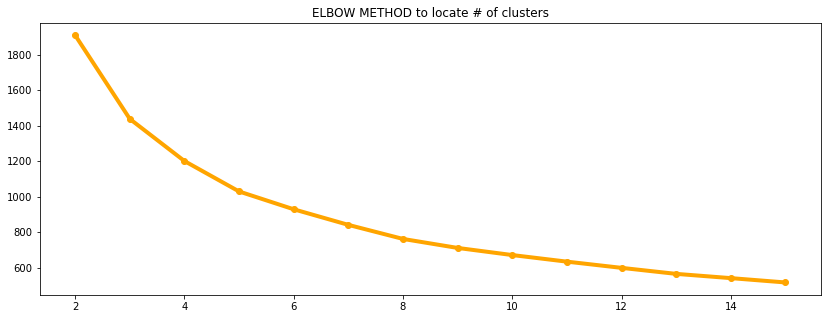

In [74]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(num_df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(14,5))
plt.title('ELBOW METHOD to locate # of clusters')
plt.plot(np.arange(2,16),inertias, marker='o', lw=4, color='orange');

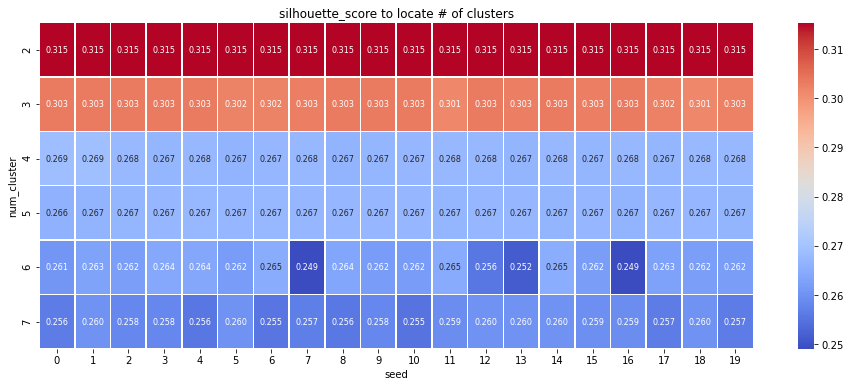

In [75]:
results = []

for cluster_n in range(2,8):
    for seed in range(20):
        kmeans = KMeans(n_clusters=cluster_n, random_state= seed)       ########
        c_labels = kmeans.fit_predict(num_df_scaled)         ##########
        sil_ave = silhouette_score(num_df_scaled, c_labels) ###########
        results.append([cluster_n, seed, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(16,6))
plt.title('silhouette_score to locate # of clusters')

plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='coolwarm', annot_kws={"size":8});

# Cluster number of 3 is chosen here

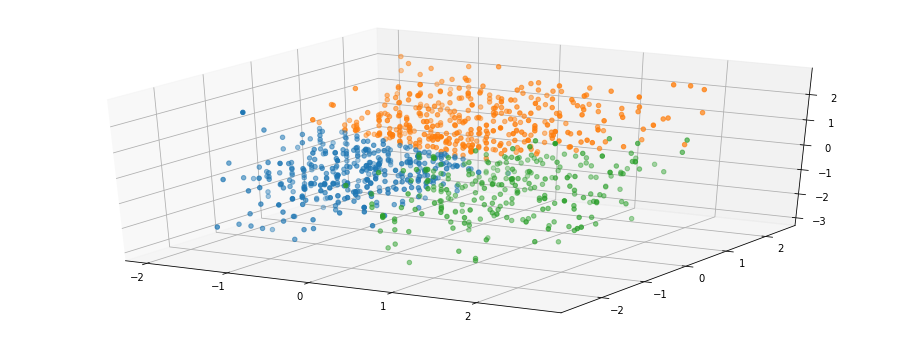

In [76]:
km = KMeans(n_clusters=3, random_state=14) ######
clusters = km.fit_predict(num_df_scaled)   #####

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(num_df_scaled[clusters ==i,0], num_df_scaled[clusters ==i,1], num_df_scaled[clusters ==i,2])

For n_clusters = 3  and seed = 14 
The average silhouette_score is : 0.30318933408774545


[<matplotlib.axis.XTick at 0x7f94661cb9d0>,
 <matplotlib.axis.XTick at 0x7f94661cb990>,
 <matplotlib.axis.XTick at 0x7f94661cb690>,
 <matplotlib.axis.XTick at 0x7f9466184850>,
 <matplotlib.axis.XTick at 0x7f9466184d90>,
 <matplotlib.axis.XTick at 0x7f946618a310>,
 <matplotlib.axis.XTick at 0x7f946618a890>]

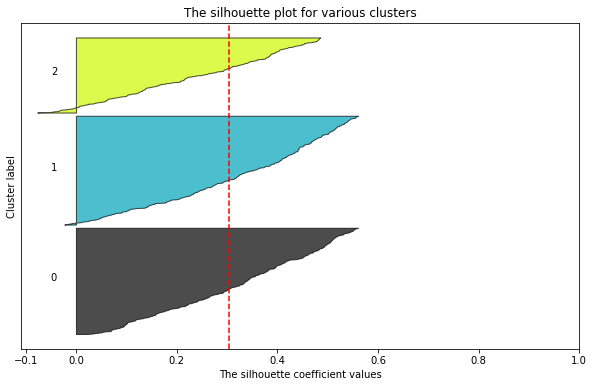

In [77]:
import matplotlib.cm as cm

cluster_scaled = num_df_scaled   #######
cluster_labels = clusters     ######
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", 14,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

km = KMeans(n_clusters=3, random_state=14)
clusters = km.fit_predict(num_df_scaled)

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(num_df_scaled[clusters ==i,0], num_df_scaled[clusters ==i,1], num_df_scaled[clusters ==i,2])

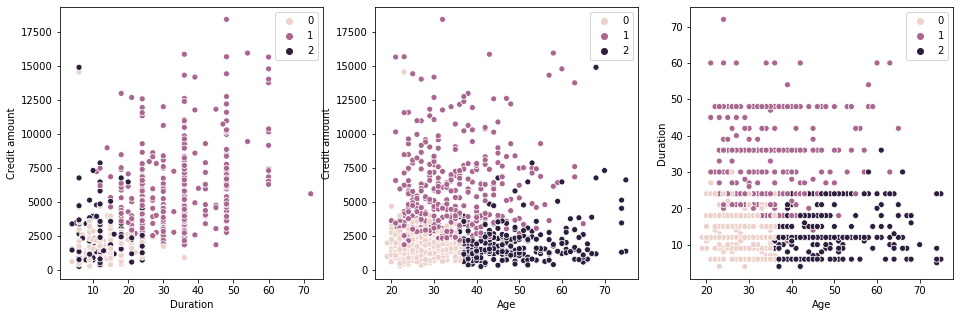

In [78]:
fig, ax  = plt.subplots(1,3,figsize=(16,5))
sns.scatterplot(df['Duration'], df['Credit amount'], hue=clusters, ax=ax[0]);
sns.scatterplot(df['Age'], df['Credit amount'], hue=clusters, ax=ax[1]);
sns.scatterplot(df['Age'], df['Duration'], hue=clusters, ax=ax[2]);

In [79]:
df_clustered = df[['Age', 'Duration', 'Credit amount']]
df_clustered['cluster'] = clusters
df_clustered.groupby('cluster').mean()

,Age,Duration,Credit amount
cluster,,,
0,27.784153,14.245902,1732.199454
1,34.042667,32.224000,5665.384000
2,48.691120,13.918919,1979.745174


# 6. XGB with random search
---

In [80]:

num_df_scaled = pd.DataFrame(num_df_scaled, columns=['Age', 'Duration', 'Credit Amount'])
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for i, cat in enumerate(categorical_features):
    df1[cat] = LabelEncoder().fit_transform(df1[cat])
cat_df = df1[categorical_features]

data = pd.concat([cat_df, num_df_scaled], axis=1)
data.head()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose,Risk,Age,Duration,Credit Amount
0,1,2,1,4,0,5,1,2.271006,-1.864869,-0.933901
1,0,2,1,0,1,5,0,-1.446152,1.708369,1.163046
2,1,1,1,0,3,3,1,1.226696,-0.673790,-0.181559
3,1,2,0,0,0,4,1,0.942455,1.478913,1.525148
4,1,2,0,0,0,1,0,1.488620,0.517289,0.904743


In [81]:
x = data.drop('Risk', axis=1)
y = data['Risk']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=14)
x_train.describe()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose,Age,Duration,Credit Amount
count,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000
mean,0.687500,1.910000,1.080000,1.113750,1.59125,2.831250,-0.009068,-0.031193,-0.021863
std,0.463802,0.657602,0.525781,1.584756,1.24945,1.995683,0.992799,1.011355,1.019971
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.935487,-2.561606,-2.921366
25%,0.000000,2.000000,1.000000,0.000000,0.00000,1.000000,-0.762586,-0.673790,-0.747937
50%,1.000000,2.000000,1.000000,0.000000,1.00000,3.000000,-0.092785,0.022947,-0.106339
75%,1.000000,2.000000,1.000000,2.000000,3.00000,5.000000,0.651845,0.517289,0.626272
max,1.000000,3.000000,2.000000,4.000000,3.00000,7.000000,2.647496,2.405105,2.619193


In [82]:
y_train.describe()

count    800.000000
mean       0.706250
std        0.455764
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Risk, dtype: float64

# SHAP

import lightgbm as lgb
import shap 

explainer = shap.Explainer(lgbm, x_train) 
shap_values = explainer(x_train) 
plt.title(label="\nMost Important Features\n", fontsize=14) 
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), max_display=20, plot_size=[9,12])

# SMOTE to balance data

from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_train, y_train = sm.fit_sample(x_train, y_train)

x_train.describe()

In [83]:
y_train.describe()

count    800.000000
mean       0.706250
std        0.455764
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Risk, dtype: float64

# Define parameter range

In [84]:

param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}

rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=140) 
rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=N

              precision    recall  f1-score   support

           0       0.65      0.48      0.55        65
           1       0.78      0.87      0.82       135

    accuracy                           0.74       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.73      0.74      0.73       200



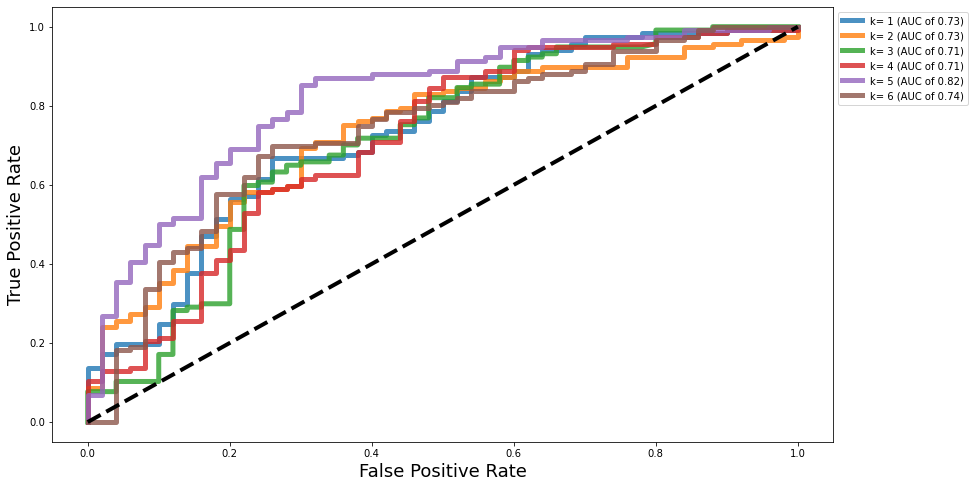

In [85]:
predictions = rs.predict(x_test)
print(classification_report(y_test, predictions))

def plot_roc(X, y, estemator,n_splits, lns = 100):
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    rf = estemator
    plt.rcParams['figure.figsize'] = (14,8)
    tprs,aucs = [],[]
    mean_fpr = np.linspace(0,1,lns)
    i = 1
    for train,test in kfold.split(X,y):
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=5, alpha=0.8, label='k= %d (AUC of %0.2f)' % (i, roc_auc))
        i= i+1
    plt.plot([0,1],[0,1],linestyle = '--',lw = 4,color = 'black')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    
xgb_model = XGBClassifier()
xgb_model.set_params(**rs.best_params_)
plot_roc(x,y, xgb_model, n_splits=6)

# Other models

LGR: 0.881135 (0.056082)
LDA: 0.879846 (0.054995)
KNN: 0.863060 (0.046620)
CART: 0.778361 (0.044262)
NB: 0.855218 (0.060629)
RF: 0.871000 (0.057153)
SVM: 0.917088 (0.043024)
XGBM: 0.851753 (0.060305)
LGBM: 0.859709 (0.043345)


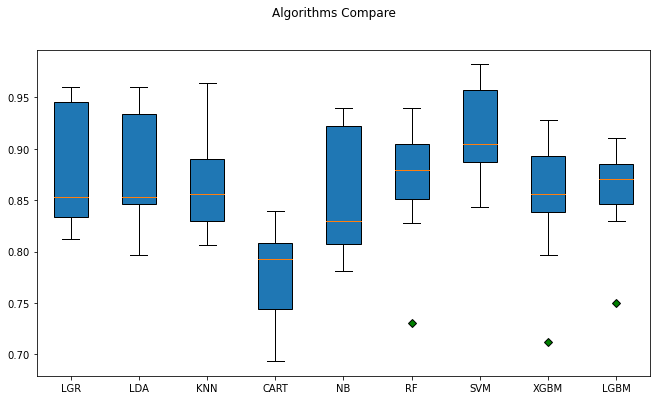

In [86]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#seed = 7
models = []
# models.append(('LR', LinearRegression()))
# models.append(('RDR', Ridge()))
# models.append(('LSSR', Lasso()))
# models.append(('ER', ElasticNet()))
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))

results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10)#, random_state=seed)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithms Compare')
ax = fig.add_subplot(111)
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
ax.set_xticklabels(names)
plt.show()

# Naive Bayes

Primitive error evaluation accuracy score:  0.7475
Test predict accuracy score:  0.71 

Confussion Matrix: 
 [[ 34  31]
 [ 27 108]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           0       0.56      0.52      0.54        65
           1       0.78      0.80      0.79       135

    accuracy                           0.71       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.71      0.71      0.71       200



Text(0.5, 1.0, 'ROC Curve')

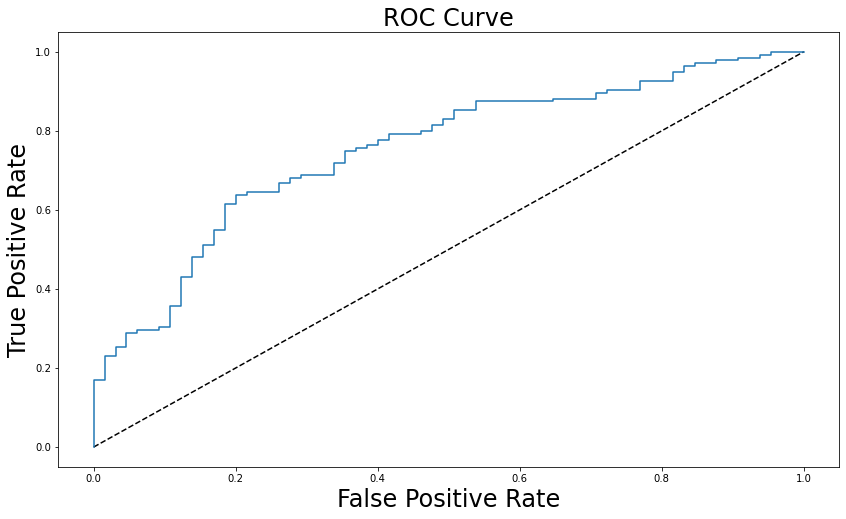

In [87]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve

GNB = GaussianNB()
model = GNB.fit(x_train, y_train)
print("Primitive error evaluation accuracy score: ", model.score(x_train, y_train))

y_pred = model.predict(x_test)
print("Test predict accuracy score: ", accuracy_score(y_test,y_pred),"\n")
print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")
print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred))

y_pred_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.title('ROC Curve',fontsize=24)

# Random Forest

In [88]:
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

model = RandomForestClassifier(random_state=14)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.938, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.965, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.903, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.938, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.938, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.938, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.938, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.982, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.947, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.938, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=10 ....................
[CV]  max_depth=3, max_features=4, n_estimators=10, score=0.956, total=   0.0s
[CV] max_depth=3, max_features=4, n_estimators=25 ....................
[CV]  max_depth=3, max_features=4, n_estimators=25, score=0.947, total=   0.1s
[CV] max_depth=3, max_features=4, n_estimators=25 ....................
[CV]  max_depth=3, max_features=4, n_estimators=25, score=0.982, total=   0.1s
[CV] max_depth=3, max

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   38.6s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=14),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [4, 7, 15, 20],
                         'n_estimators': [3, 5, 10, 25, 50, 150]},
             scoring='recall', verbose=4)

In [89]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.952212389380531
{'max_depth': 3, 'max_features': 4, 'n_estimators': 5}


In [90]:
rf = RandomForestClassifier(max_depth=None, max_features=4, n_estimators=50, random_state=14)
rf.fit(x_train, y_train)

RandomForestClassifier(max_features=4, n_estimators=50, random_state=14)

In [91]:
y_pred = rf.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(fbeta_score(y_test, y_pred, beta=2))

0.715
[[ 27  38]
 [ 19 116]]
0.835734870317003


# Pipeline

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest


features = []
features.append(('PCA', PCA(n_components=2)))
features.append(('Select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('Feature_union', feature_union))
estimators.append(('Logistic_regression', LogisticRegression()))
model = Pipeline(estimators)

seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, x_train, y_train, cv=kfold)
print(results.mean())
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Test predict accuracy score: {:.2f}".format(accuracy_score(y_test,y_pred)),"\n")
print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")
print("Weighted harmonic mean of precision according to Test prediction: ", fbeta_score(y_test, y_pred, beta=2))

0.7337499999999999
Test predict accuracy score: 0.71 

Confussion Matrix: 
 [[ 29  36]
 [ 21 114]] 

Weighted harmonic mean of precision according to Test prediction:  0.826086956521739


# References:

https://www.kaggle.com/code/delllectron/bank-credit-data-clustering-modelling

segmentation:
https://www.kaggle.com/code/paulinan/bank-customer-segmentation

models: 
https://www.kaggle.com/code/hendraherviawan/predicting-german-credit-default#5.-Others

https://www.kaggle.com/code/mathchi/credit-risk-evaluation#3.-Data-Prepcoressing-&-Feature-Engineering

pipeline: 
https://www.kaggle.com/code/mathchi/credit-risk-evaluation


other data:
https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset

https://www.kaggle.com/code/janiobachmann/german-credit-analysis-a-risk-perspective/data

https://www.kaggle.com/code/manikhindwan/credit-risk-management-modelling-expected-loss/notebook

https://www.kaggle.com/code/janiobachmann/lending-club-risk-analysis-and-metrics/notebook

https://www.kaggle.com/code/psycon/credit-risk-analysis-eda-statistics-visualization/notebook
